## Machine Learning for Chemistry (CH-610) - Project

## Abstract

Understanding the protein folding and unfolding process remains the challenge of the Computational Biophysical process. MD Simulations generate a high dimensional trajectory files, which makes the analysis a cumbersome and computational expensive process. In this work, we employed the neural network based dimensionality reduction techniques to get the low dimensional features and slow mode representation which captures the transition of folded to unfolded states. Specifically,the autoencoders learn the latent space embeedings that capture the folding and unfolding pathways, while preserving the structural integrity. And we compared our approach with the other methods such as the principal component analysis (PCA) and time-lagged independent component analysis (TICA), to comprehend the efficacy of our approach towards the folding -unfolding dynamics. This approach will contribute to the growing intersection of deep learning and molecular biophysics, offering novel insights into protein conformational dynamics.

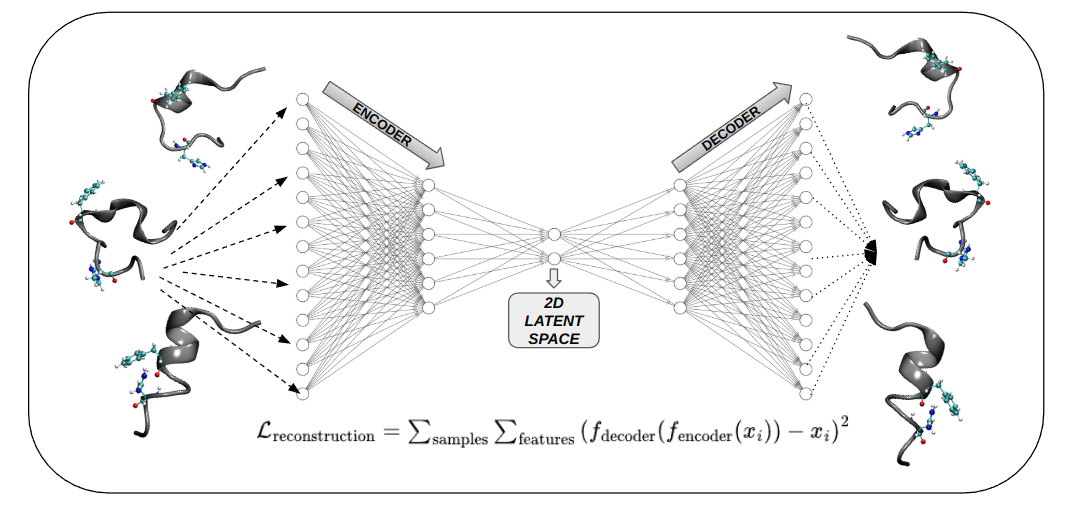

#AutoEncoder Based Neural Network Model for the classification of the Protein

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

#105 Distance as input Descriptors (all C-α atoms)

In [ ]:
df1 = pd.read_csv('all_states.csv')
df1

,time,rms,rg,ic1,ic2,etoe,d1,d2,d3,d4,...,d97,d98,d99,d100,d101,d102,d103,d104,d105,State
0,0.000000,0.0470,0.7760,0.4100,0.3948,2.0190,0.4760,0.6962,0.5352,0.7041,...,0.9223,0.5174,0.7716,0.4435,0.4891,0.7113,0.6860,0.7786,0.2968,0.0
1,0.100000,0.0420,0.7769,0.4319,0.3956,2.0451,0.4784,0.7403,0.5174,0.6990,...,0.9494,0.5347,0.7864,0.4640,0.4917,0.7133,0.6966,0.7802,0.3074,0.0
2,0.200000,0.0402,0.7813,0.4468,0.3973,2.0262,0.4617,0.7167,0.5184,0.7306,...,0.9459,0.5411,0.7793,0.4533,0.4987,0.6999,0.7204,0.8016,0.3001,0.0
3,0.300000,0.0400,0.7808,0.4277,0.3847,2.0144,0.4652,0.7172,0.5118,0.7174,...,0.9467,0.5325,0.7788,0.4487,0.4796,0.6801,0.7284,0.7969,0.3301,0.0
4,0.400000,0.0518,0.7762,0.4176,0.3959,2.0050,0.4655,0.7313,0.5074,0.7070,...,0.9557,0.5348,0.7720,0.4618,0.5278,0.7364,0.7693,0.8481,0.3457,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29998,999.600047,0.4643,0.7371,1.1154,0.9866,1.4998,0.4693,0.8184,0.4465,0.6782,...,0.8270,0.5163,0.3769,0.4169,0.4449,0.4429,0.7506,0.7650,0.4113,2.0
29999,999.700047,0.4620,0.7390,1.1050,0.9475,1.5026,0.4841,0.8569,0.4681,0.6965,...,0.8373,0.5361,0.3795,0.4156,0.4800,0.4327,0.7845,0.7659,0.4198,2.0
30000,999.800047,0.4607,0.7394,1.0976,0.9314,1.4839,0.4711,0.8165,0.4602,0.6825,...,0.8299,0.5292,0.3602,0.4097,0.4856,0.4392,0.7996,0.7485,0.4264,2.0
30001,999.900047,0.4604,0.7393,1.0949,0.9301,1.4739,0.4810,0.8699,0.4521,0.6781,...,0.8247,0.5246,0.3995,0.4093,0.4952,0.4201,0.7949,0.7375,0.4130,2.0


In [ ]:
X = df1.filter(regex='d').values
Y = df1[['State']].values

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.25, random_state=1)
#25 % for training.

X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_train_norm = torch.from_numpy(X_train_norm).float()
y_train = torch.from_numpy(y_train)

X_test_norm = (X_test - np.mean(X_test)) / np.std(X_test)
X_test_norm = torch.from_numpy(X_test_norm).float()
y_test = torch.from_numpy(y_test)

train_ds = TensorDataset(X_train_norm, y_train)
test_ds = TensorDataset(X_test_norm, y_test)

torch.manual_seed(1)
batch_size = X_train.shape[0]
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size, shuffle=True)

print(Y.shape)

(30003, 1)


In [ ]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        # 105 ==> 250 ==> 2
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(105, 250),
            torch.nn.Sigmoid(),
            torch.nn.Linear(250, 2)
        )

        # Decoder
        # 2 ==> 250 ==> 105
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(2, 250),
            torch.nn.Sigmoid(),
            torch.nn.Linear(250, 105)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
model = AE()

optimizer = torch.optim.Adam(model.parameters(),
							lr = 1e-3, weight_decay=1e-5)

#loss function
loss_def = nn.MSELoss()

In [ ]:
num_epochs = 200
loss_hist = []

for epoch in range(num_epochs):

    for x_batch, y_batch in train_dl:
        x_reconstructed = model(x_batch)

        loss = loss_def(x_reconstructed, x_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    loss_hist.append(loss.item())
    if epoch % 10 == 0:
      print(f'Epoch {epoch}  Loss {loss_hist[-1]:.4f}')

Epoch 0  Loss 1.0494
Epoch 10  Loss 0.3066
Epoch 20  Loss 0.2432
Epoch 30  Loss 0.1702
Epoch 40  Loss 0.1379
Epoch 50  Loss 0.1253
Epoch 60  Loss 0.1214
Epoch 70  Loss 0.1196
Epoch 80  Loss 0.1184
Epoch 90  Loss 0.1166
Epoch 100  Loss 0.1123
Epoch 110  Loss 0.1009
Epoch 120  Loss 0.0833
Epoch 130  Loss 0.0726
Epoch 140  Loss 0.0666
Epoch 150  Loss 0.0645
Epoch 160  Loss 0.0638
Epoch 170  Loss 0.0633
Epoch 180  Loss 0.0631
Epoch 190  Loss 0.0629


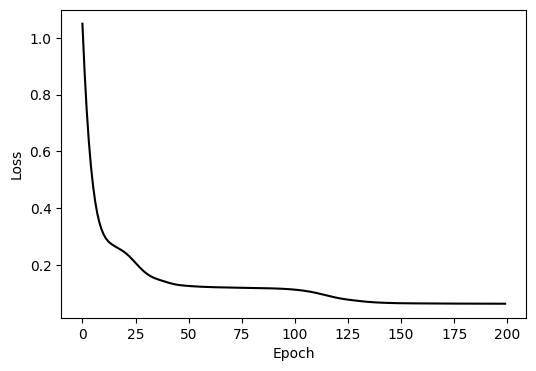

In [ ]:
epochs = np.arange(num_epochs)

plt.figure(figsize=(6,4),dpi=100)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(epochs,loss_hist,color='k')

In [ ]:
enc = model.encoder(X_train_norm)
enc_np = enc.detach().numpy()
#print(enc_np)
np.shape(X_test_norm)

torch.Size([7501, 105])

In [ ]:
encc = model.encoder(X_test_norm)
encc_np = encc.detach().numpy()

In [ ]:
with torch.no_grad():
  x_AE = model.encoder(X_train_norm)
x_AE_np = x_AE.numpy()

with torch.no_grad():
  x_AE_test = model.encoder(X_test_norm)
x_AE_np_test = x_AE_test.numpy()

Text(0.5, 1.0, 'Training Data')

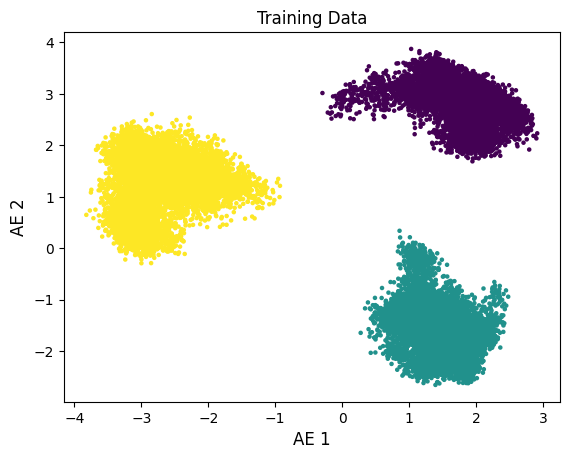

In [ ]:
plt.scatter(x_AE_np[:,0],x_AE_np[:,1],c=y_train,cmap='viridis',s=5)
plt.xlabel('AE 1',fontsize=12)
plt.ylabel('AE 2',fontsize=12)
plt.title('Training Data')

Text(0.5, 1.0, 'Test Data')

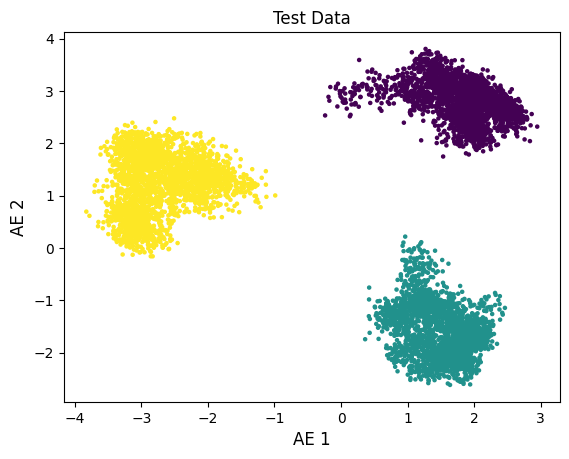

In [ ]:
plt.scatter(x_AE_np_test[:,0],x_AE_np_test[:,1],c=y_test,cmap='viridis',s=5)
plt.xlabel('AE 1',fontsize=12)
plt.ylabel('AE 2',fontsize=12)
plt.title('Test Data')

# Clustering by the K-Means and DBSCAN method on the Autoencoder NN's 2D Latent Space

Text(0, 0.5, '$AE 2$')

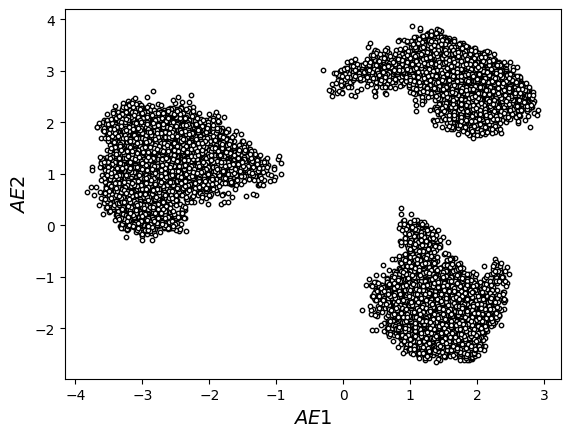

In [ ]:
# @title Scatter plot of NN-AE

ac1 = np.array(x_AE_np[:,0])
ac2 = np.array(x_AE_np[:,1])

plt.scatter(ac1,ac2,c='white', marker='.', edgecolor='black', s=40)
plt.xlabel('$AE 1$',fontsize=14)
plt.ylabel('$AE 2$',fontsize=14)

In [ ]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3,
            init='random',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)

y_km = km.fit_predict(x_AE_np[:,:2])
AE_x = ac1
AE_y = ac2

print('Cluster ID: ',y_km)
print('Cluster centers: ',km.cluster_centers_)

Cluster ID:  [1 1 0 ... 1 0 2]
Cluster centers:  [[ 1.8487898  2.7915816]
 [ 1.4906274 -1.5934987]
 [-2.6910372  1.2076515]]


In [ ]:
print('Distortion: %f' % km.inertia_)

Distortion: 10334.467773


Text(0, 0.5, '$Distortion$')

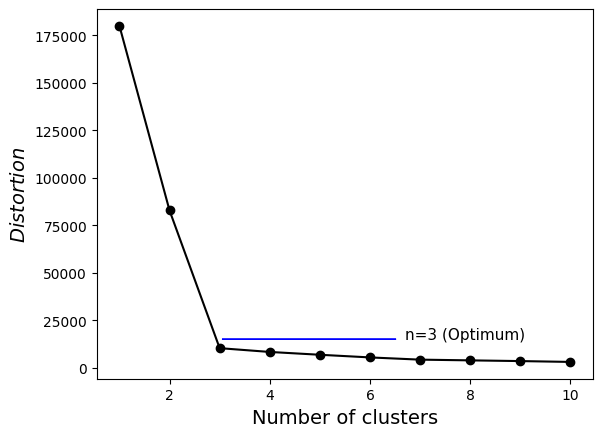

In [ ]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i,
                init='random',
                n_init=10,
                max_iter=300,
                random_state=0)
    km.fit_predict(x_AE_np[:,:2])
    distortions.append(km.inertia_)
plt.plot(range(1, 11), distortions, marker='o',color='k')
plt.arrow(3.4, 15000, 1, 1, width=1, head_width=1, head_length=3, fc='r', ec='b')
plt.text(6.7,15000 ,'n=3 (Optimum)', fontsize = 11)
plt.xlabel('Number of clusters',fontsize=14)
plt.ylabel('$Distortion$',fontsize=14)
#plt.grid(True)

In [ ]:
from sklearn.metrics import silhouette_samples

km = KMeans(n_clusters=3,
            init='random',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)

y_km = km.fit_predict(x_AE_np[:,:2])

silhouette_vals = silhouette_samples(x_AE_np[:,:2], y_km, metric='euclidean')
silhouette_vals

array([0.8546195 , 0.81164557, 0.85832775, ..., 0.8500057 , 0.85021394,
       0.8005031 ], dtype=float32)

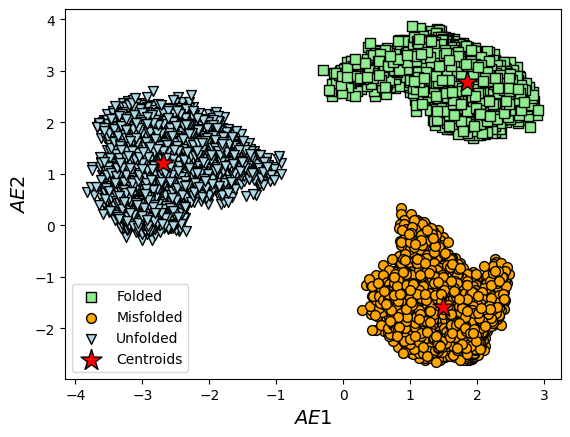

In [ ]:
# @title Clustering Plot

plt.scatter(ac1[y_km == 0],
            ac2[y_km == 0],
            s=50, c='lightgreen',
            marker='s', edgecolor='black',
            label='Folded')
plt.scatter(ac1[y_km == 1],
            ac2[y_km == 1],
            s=50, c='orange',
            marker='o', edgecolor='black',
            label='Misfolded')
plt.scatter(ac1[y_km == 2],
            ac2[y_km == 2],
            s=50, c='lightblue',
            marker='v', edgecolor='black',
            label='Unfolded')
plt.scatter(km.cluster_centers_[:, 0],
            km.cluster_centers_[:, 1],
            s=250, marker='*',
            c='red', edgecolor='black',
            label='Centroids')

#plt.grid()
plt.xlabel('$AE 1$',fontsize=14)
plt.ylabel('$AE 2$',fontsize=14)
plt.legend(scatterpoints=1)

Text(0.5, 0, 'Silhouette coefficient')

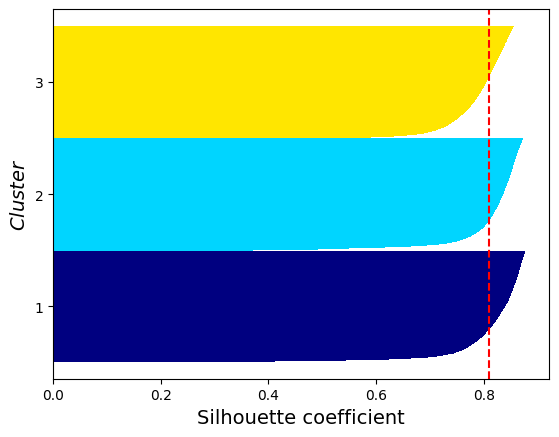

In [ ]:
# @title Silhouette Value plot

from matplotlib import cm
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0,
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--")

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('$Cluster$',fontsize=14)
plt.xlabel('Silhouette coefficient',fontsize=14)

In [ ]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.25, min_samples=30, metric='euclidean')
y_db = db.fit_predict(x_AE_np[:,:2])

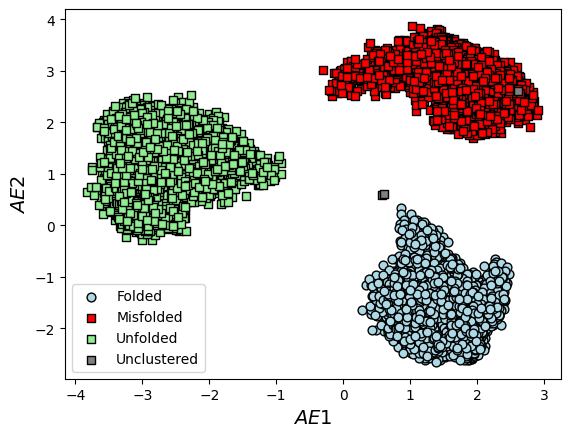

In [ ]:
plt.scatter(ac1[y_db == 0], ac2[y_db == 0],
            c='lightblue', marker='o', s=40,
            edgecolor='black',
            label='Folded')
plt.scatter(ac1[y_db == 1], ac2[y_db == 1],
            c='red', marker='s', s=40,
            edgecolor='black',
            label='Misfolded')
plt.scatter(ac1[y_db == 2], ac2[y_db == 2],
            c='lightgreen', marker='s', s=40,
            edgecolor='black',
            label='Unfolded')
plt.scatter(ac2[y_db == -1], ac2[y_db == -1],
            c='gray', marker='s', s=40,
            edgecolor='black',
            label='Unclustered')

plt.xlabel('$AE 1$',fontsize=14)
plt.ylabel('$AE 2$',fontsize=14)
plt.legend()

# Time-lagged independent component analysis (TICA) on the Global features of the Protein

In [ ]:
!pip install deeptime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.5 MB/s eta 0:00:00


In [ ]:
from deeptime.decomposition import TICA
t = np.arange(len(df1))
df_tica = df1[['rms','rg','ic1','ic2','etoe','State']]
df_tica.head(5)

,rms,rg,ic1,ic2,etoe,State
0,0.0470,0.7760,0.4100,0.3948,2.0190,0.0
1,0.0420,0.7769,0.4319,0.3956,2.0451,0.0
2,0.0402,0.7813,0.4468,0.3973,2.0262,0.0
3,0.0400,0.7808,0.4277,0.3847,2.0144,0.0
4,0.0518,0.7762,0.4176,0.3959,2.0050,0.0


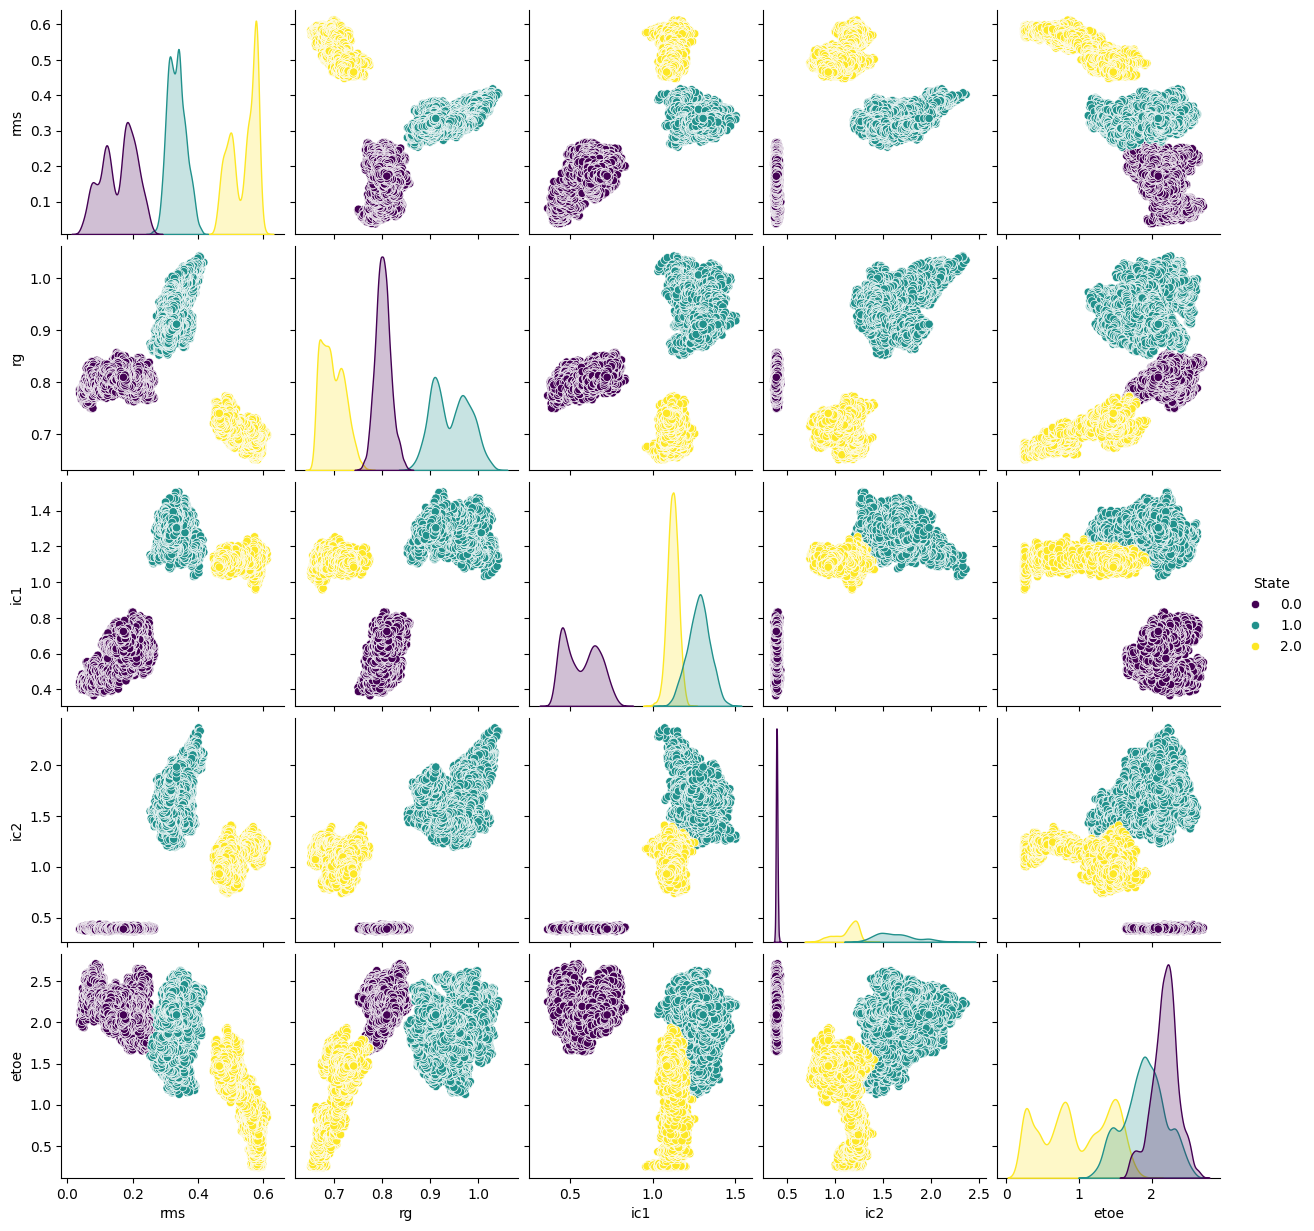

In [ ]:
import seaborn as sns

sns.pairplot(df_tica,hue='State',palette='viridis')

In [ ]:
df_tica_with_time = df_tica.copy()
df_tica_with_time['time'] = t
df_tica_with_time.head(5)

,rms,rg,ic1,ic2,etoe,State,time
0,0.0470,0.7760,0.4100,0.3948,2.0190,0.0,0
1,0.0420,0.7769,0.4319,0.3956,2.0451,0.0,1
2,0.0402,0.7813,0.4468,0.3973,2.0262,0.0,2
3,0.0400,0.7808,0.4277,0.3847,2.0144,0.0,3
4,0.0518,0.7762,0.4176,0.3959,2.0050,0.0,4


In [ ]:
tica = TICA(dim=3, lagtime=2)
x = df_tica_with_time[['rms','rg','ic1','ic2','etoe']].values
x_tica = tica.fit_transform(x)
print(x_tica)

[[-1.52684024 -0.90415777 -1.44339462]
 [-1.54399707 -0.88621572 -1.38705695]
 [-1.55592652 -0.85537465 -1.49536391]
 ...
 [ 0.65305761 -0.52523776  0.95249618]
 [ 0.65189665 -0.52842534  0.91355044]
 [ 0.6668327  -0.53081941  0.93192096]]


In [ ]:
y = df1['State'].values.reshape(-1, 1)

projected_data_1 = np.concatenate((x_tica, y), axis=1)

df_tica_updated = pd.DataFrame(projected_data_1, columns=['TICA 1','TICA 2','TICA 3','State'])
df_tica_updated.head(5)

,TICA 1,TICA 2,TICA 3,State
0,-1.526840,-0.904158,-1.443395,0.0
1,-1.543997,-0.886216,-1.387057,0.0
2,-1.555927,-0.855375,-1.495364,0.0
3,-1.565614,-0.878244,-1.548260,0.0
4,-1.504943,-0.901880,-1.449185,0.0


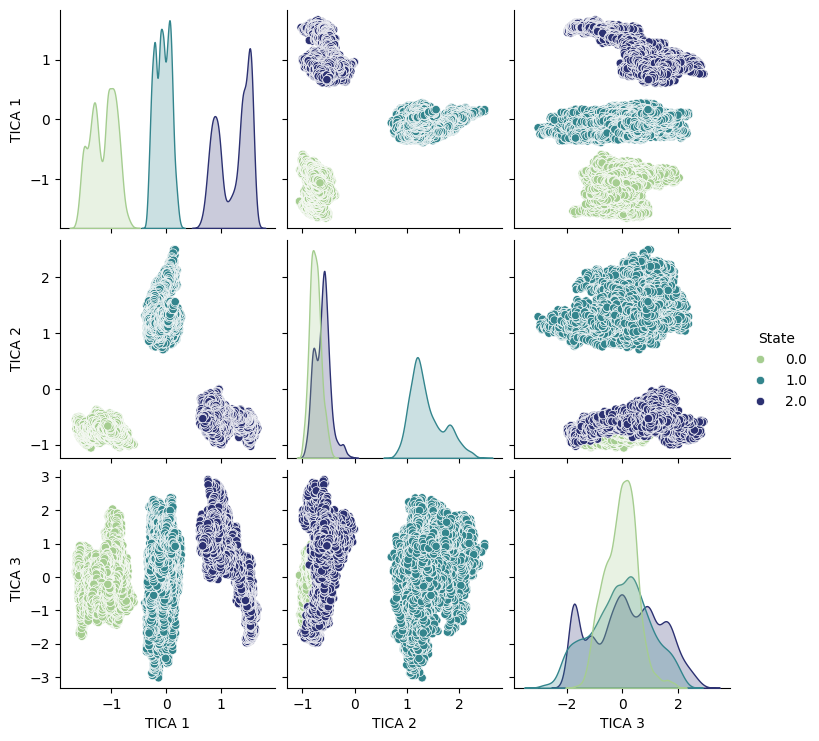

In [ ]:
sns.pairplot(df_tica_updated,hue='State',palette='crest')

# Principal component analysis (PCA) on the Global features of the Protein

In [ ]:
df_pca = df1[['rms','rg','ic1','ic2','etoe','State']]
df_pca.head(5)

,rms,rg,ic1,ic2,etoe,State
0,0.0470,0.7760,0.4100,0.3948,2.0190,0.0
1,0.0420,0.7769,0.4319,0.3956,2.0451,0.0
2,0.0402,0.7813,0.4468,0.3973,2.0262,0.0
3,0.0400,0.7808,0.4277,0.3847,2.0144,0.0
4,0.0518,0.7762,0.4176,0.3959,2.0050,0.0


In [ ]:
X_pca_inp = df1.filter(regex='rms|rg|ic1|ic2|etoe').values
print(X_pca_inp)

[[0.047  0.776  0.41   0.3948 2.019 ]
 [0.042  0.7769 0.4319 0.3956 2.0451]
 [0.0402 0.7813 0.4468 0.3973 2.0262]
 ...
 [0.4607 0.7394 1.0976 0.9314 1.4839]
 [0.4604 0.7393 1.0949 0.9301 1.4739]
 [0.4657 0.7401 1.0842 0.9305 1.4701]]


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(X_pca_inp)

PCA(n_components=3)

In [ ]:
print(pca.explained_variance_ratio_)

for i in range(len(pca.explained_variance_ratio_)):
    print('PC %d: %0.2f'%(i+1,pca.explained_variance_ratio_[i]*100))

[0.64313518 0.33514349 0.01535038]
PC 1: 64.31
PC 2: 33.51
PC 3: 1.54


In [ ]:
import numpy as np
X_pca = pca.fit_transform(X_pca_inp)
y = df1.filter(regex='State').values
pca_data = np.concatenate((X_pca,y),axis=1)
#y.shape

In [ ]:
df_pca = pd.DataFrame(pca_data, columns=['PC 1','PC 2','PC 3','state'])
df_pca.head(5)

,PC 1,PC 2,PC 3,state
0,0.873043,-0.397596,-0.214265,0.0
1,0.884950,-0.373436,-0.194351,0.0
2,0.865385,-0.378906,-0.187050,0.0
3,0.870437,-0.400873,-0.198866,0.0
4,0.858527,-0.403682,-0.209284,0.0


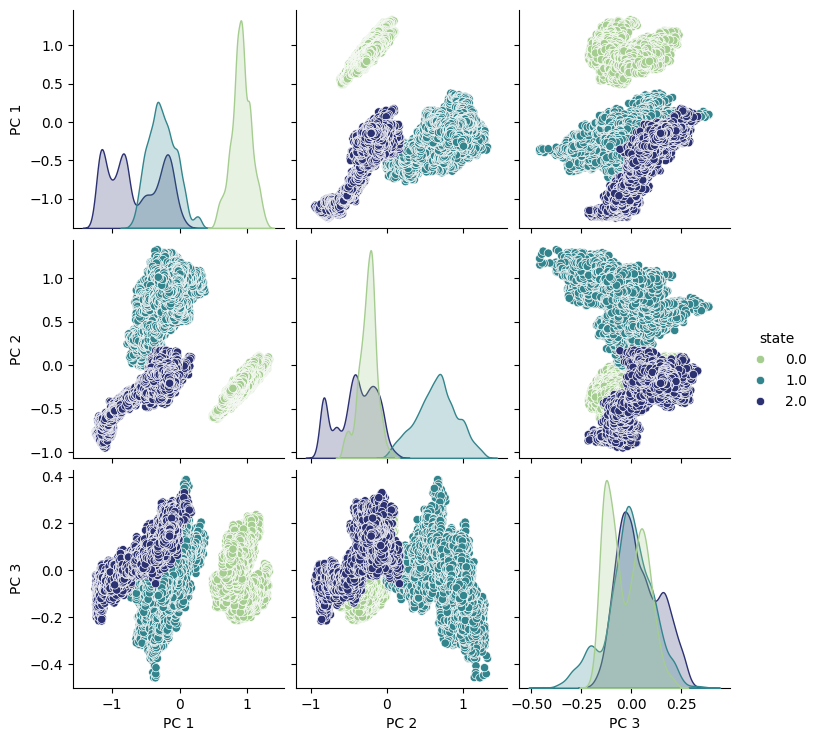

In [ ]:
sns.pairplot(df_pca,hue='state',palette='crest')